# Understanding Tennis Player Movements Through Pose Detection

## Importing libraries

In [462]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2 as cv

## Define Keypoints and Body Connections
Defines all the body parts and their pairwise connections for pose estimation.




In [463]:
# Mapping of body keypoints to their corresponding indices
KEYPOINTS = {
    "Head": 0, "Spine": 1, "RightShoulder": 2, "RightElbow": 3, "RightHand": 4,
    "LeftShoulder": 5, "LeftElbow": 6, "LeftHand": 7, "RightHip": 8, "RightKnee": 9,
    "RightFoot": 10, "LeftHip": 11, "LeftKnee": 12, "LeftFoot": 13,
    "RightEye": 14, "LeftEye": 15, "RightEar": 16, "LeftEar": 17, "Background": 18
}

# Keypoint connections to represent body limbs or segments
SKELETON_CONNECTIONS = [
    ("Spine", "RightShoulder"), ("Spine", "LeftShoulder"),
    ("RightShoulder", "RightElbow"), ("RightElbow", "RightHand"),
    ("LeftShoulder", "LeftElbow"), ("LeftElbow", "LeftHand"),
    ("Spine", "RightHip"), ("RightHip", "RightKnee"), ("RightKnee", "RightFoot"),
    ("Spine", "LeftHip"), ("LeftHip", "LeftKnee"), ("LeftKnee", "LeftFoot"),
    ("Spine", "Head"), ("Head", "RightEye"), ("RightEye", "RightEar"),
    ("Head", "LeftEye"), ("LeftEye", "LeftEar")
]


## Initialize Pose Model and Input Dimensions
Loads the pre-trained pose detection network and sets the frame size for processing.




In [ ]:
# Set the dimensions for input images
FRAME_WIDTH = 600
FRAME_HEIGHT = 600

# Load the pre-trained pose estimation model
import cv2 as cv
pose_model = cv.dnn.readNetFromTensorflow("/content/pose.pb")


## Load Input Image
Reads the image from the given path and extracts its dimensions.



In [465]:
# Load an image from file
input_image = cv.imread('/content/Untitled Folder/input7.jpg', cv.IMREAD_UNCHANGED)

# Extract dimensions from the loaded image
height, width = input_image.shape[:2]


## Run Pose Estimation
Converts the image into a blob, feeds it into the network, and performs forward pass to get pose data.

In [466]:
# Convert the image into a blob for neural network input
input_blob = cv.dnn.blobFromImage(input_image, scalefactor=1.0, size=(FRAME_WIDTH, FRAME_HEIGHT),
                                  mean=(127.5, 127.5, 127.5), swapRB=True, crop=False)

# Feed the blob into the model
pose_model.setInput(input_blob)

# Perform a forward pass and retrieve the output for the first 19 keypoints
pose_output = pose_model.forward()[:, :19, :, :]


## Extract and Filter Keypoints
Processes the network output to identify body part coordinates above a confidence threshold.

In [467]:
# Set confidence threshold for valid keypoint detection
CONFIDENCE_THRESHOLD = 0.2

# Initialize a list to hold keypoint coordinates
keypoints = []

# Iterate through all defined keypoint indices
for idx in range(len(KEYPOINTS)):
    # Extract the probability heatmap for the current keypoint
    heatmap = pose_output[0, idx, :, :]

    # Get the maximum confidence and location from the heatmap
    _, max_confidence, _, max_point = cv.minMaxLoc(heatmap)

    # Scale the point to match the original image dimensions
    coord_x = int((width * max_point[0]) / pose_output.shape[3])
    coord_y = int((height * max_point[1]) / pose_output.shape[2])

    # Add the point if it exceeds the confidence threshold
    keypoints.append((coord_x, coord_y) if max_confidence > CONFIDENCE_THRESHOLD else None)


## Draw Skeleton Connections
Draws lines and dots to connect detected body parts and visualize the skeleton.



In [468]:
# Connect keypoint pairs with lines and markers
for connection in SKELETON_CONNECTIONS:
    start_name, end_name = connection
    start_id, end_id = KEYPOINTS[start_name], KEYPOINTS[end_name]

    # Ensure both keypoints were detected
    if keypoints[start_id] and keypoints[end_id]:
        # Draw a line between the two detected points
        cv.line(input_image, keypoints[start_id], keypoints[end_id], (255, 0, 0), thickness=5)

        # Mark each point with a red dot
        cv.ellipse(input_image, keypoints[start_id], (3, 3), 0, 0, 360, (0, 0, 255), thickness=cv.FILLED)
        cv.ellipse(input_image, keypoints[end_id], (3, 3), 0, 0, 360, (0, 0, 255), thickness=cv.FILLED)


## Display Resulting Image
Renders the final image and handles window cleanup after displaying it.



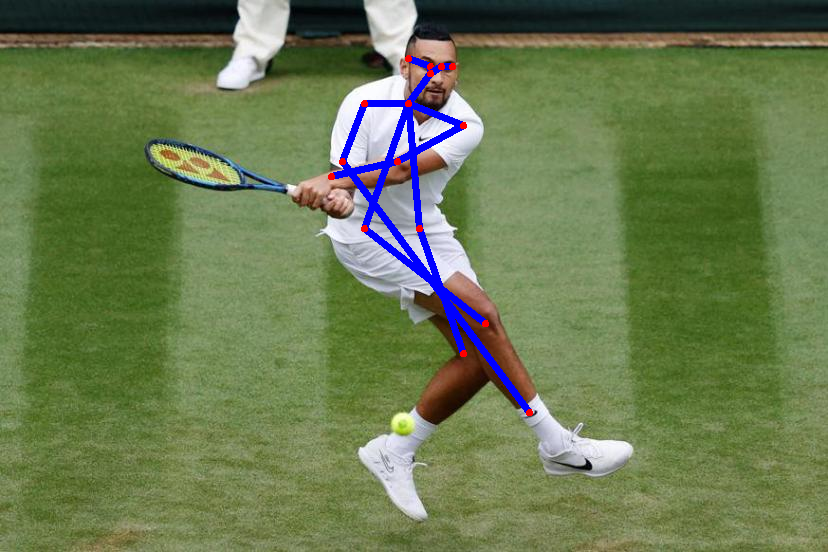

In [469]:
# Show the final output image with drawn keypoints
from google.colab.patches import cv2_imshow
cv2_imshow(input_image)

## Render Pose Skeleton on Blank Canvas
Creates a black background and draws only the pose structure for a clean, focused visualization.


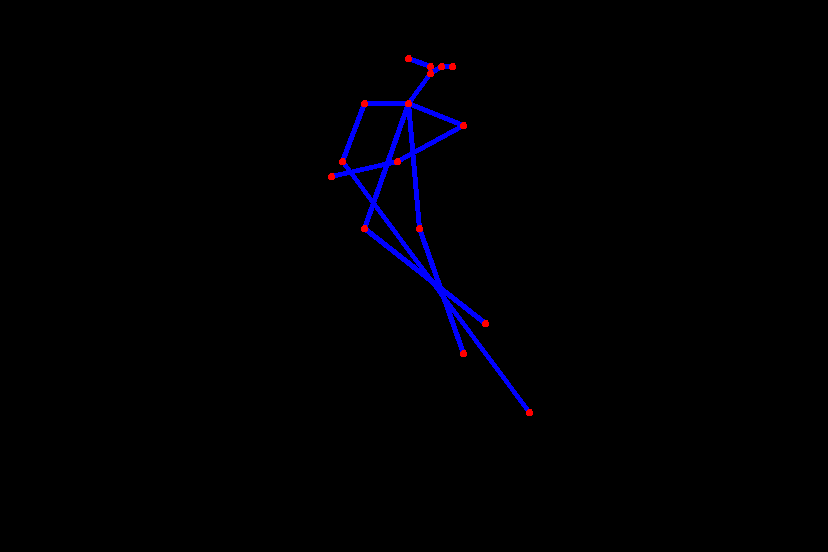

In [470]:
## Creating a blank image
blank_image = np.zeros(input_image.shape, dtype=np.uint8)

## Joining body parts on the blank image
for connection in SKELETON_CONNECTIONS:
    start_name, end_name = connection
    start_id, end_id = KEYPOINTS[start_name], KEYPOINTS[end_name]
    if keypoints[start_id] and keypoints[end_id]:
        cv.line(blank_image, keypoints[start_id], keypoints[end_id], (255, 0, 0), thickness=3)
        cv.ellipse(blank_image, keypoints[start_id], (3, 3), 0, 0, 360, (0, 0, 255), thickness=cv.FILLED)
        cv.ellipse(blank_image, keypoints[end_id], (3, 3), 0, 0, 360, (0, 0, 255), thickness=cv.FILLED)

## Showing the blank image with the pose structure
from google.colab.patches import cv2_imshow
cv2_imshow(blank_image)



## Pose Data Analysis

Calculates the Angle

In [471]:
import math
import numpy as np
import cv2 as cv

def calculate_angle(a, b, c):
    if a is None or b is None or c is None:
        return None
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-6)
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)


In [472]:
# Define joint triplets for angle calculation
angle_triplets = [
    ("RightShoulder", "RightElbow", "RightHand"),
    ("LeftShoulder", "LeftElbow", "LeftHand"),
    ("RightHip", "RightKnee", "RightFoot"),
    ("LeftHip", "LeftKnee", "LeftFoot"),
    ("Spine", "RightShoulder", "RightElbow"),
    ("Spine", "LeftShoulder", "LeftElbow"),
    ("RightShoulder", "Spine", "LeftShoulder"),  # Shoulder angle across torso
    ("RightHip", "Spine", "LeftHip"),            # Hip angle across pelvis
]

# Function to adjust position to avoid overlap
def adjust_text_position(base_point, offset=(10, -10)):
    return (base_point[0] + offset[0], base_point[1] + offset[1])

# Draw angles on image
used_positions = set()  # To keep track of positions already used
for a_name, b_name, c_name in angle_triplets:
    a = keypoints[KEYPOINTS[a_name]]
    b = keypoints[KEYPOINTS[b_name]]
    c = keypoints[KEYPOINTS[c_name]]

    angle = calculate_angle(a, b, c)
    if angle is not None:
        angle_text = f"{int(angle)}"
        text_position = b

        # Adjust text position to avoid overlap with existing text
        offset = (10, -10)  # Start with a small offset
        new_position = adjust_text_position(text_position, offset)

        while new_position in used_positions:
            offset = (offset[0], offset[1] - 10)  # Change vertical offset
            new_position = adjust_text_position(text_position, offset)

        used_positions.add(new_position)

        # Add text on the image
        cv.putText(input_image, angle_text, new_position, cv.FONT_HERSHEY_COMPLEX, 0.5, (255, 0, 255), 1)


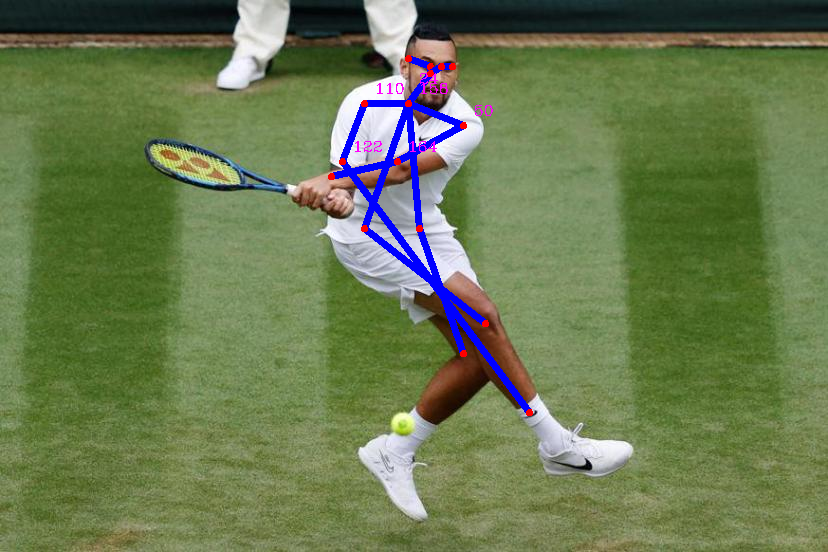

In [473]:
cv2_imshow(input_image)